In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("preprocessing_and_filtering/processed_data.csv")

## Superstores

In [3]:
## Import the data and filter for the good superstores

superstores = list(pd.read_csv("stores_to_use/final_super_stores.csv")["0"])

df_superstores = df[df['Location ID'].isin(superstores)]
df_superstores = df_superstores.dropna()

df_superstores = df_superstores[["Tonnage", 
                                 "Completed Date",
                                 "Latitude", 
                                 "Longitude", 
                                 "Days Since Last Pickup", 
                                 "Last Pickup Tonnage",
                                 "Second Last Pickup Tonnage",
                                 "Third Last Pickup Tonnage",
                                 "Weekdays Since Last Pickup",
                                 "Weekend Days Since Last Pickup",
                                 "Days Before Last Pickup",
                                 "Days Before Second Last Pickup",
                                 "Days Before Third Last Pickup",
                                 "Month"]]

# Convert 'Completed Date' to datetime
df_superstores['Completed Date'] = pd.to_datetime(df_superstores['Completed Date'])

# Sort DataFrame by 'Completed Date'
df_superstores = df_superstores.sort_values('Completed Date')

# Define the split date
split_date = pd.Timestamp('2023-02-01')

# Split the data into training and testing sets
train = df_superstores[df_superstores['Completed Date'] < split_date]
test = df_superstores[df_superstores['Completed Date'] >= split_date]

# Define the target variable 'Tonnage'
y_train = train['Tonnage']
y_test = test['Tonnage']

# Drop the target variable and 'Completed Date' from features
X_train = train.drop(['Tonnage', 'Completed Date'], axis=1)
X_test = test.drop(['Tonnage', 'Completed Date'], axis=1)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (41931, 12)
Testing set size: (18042, 12)


In [6]:
## Normalize the data

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
## Run the different models

# Models setup
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting Regressor': GradientBoostingRegressor()
}

# Training and testing each model
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Training model
    y_pred = model.predict(X_test_scaled)  # Predicting on test set
    
    # Evaluating model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R^2 Score': r2}

# Displaying results
for name, scores in results.items():
    print(f"{name} - MSE: {scores['MSE']:.2f}, R^2 Score: {scores['R^2 Score']:.2f}")

Linear Regression - MSE: 4.00, R^2 Score: 0.24
Ridge Regression - MSE: 4.00, R^2 Score: 0.24
Lasso Regression - MSE: 5.24, R^2 Score: -0.00
Decision Tree Regressor - MSE: 7.38, R^2 Score: -0.41
Random Forest Regressor - MSE: 3.68, R^2 Score: 0.30
Support Vector Regressor - MSE: 3.52, R^2 Score: 0.33
Gradient Boosting Regressor - MSE: 3.63, R^2 Score: 0.31


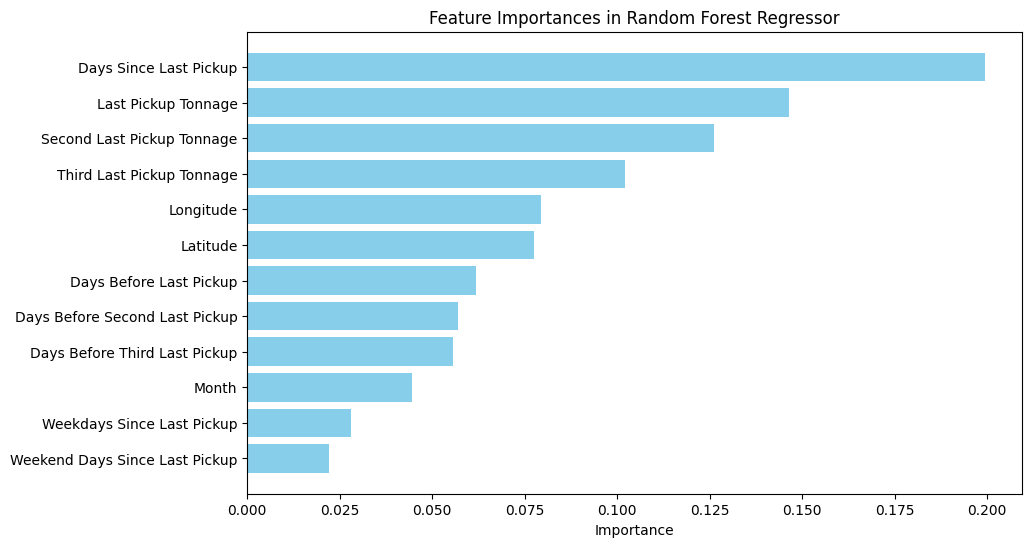

In [49]:
## Analyze feature importance

# Create the regressor model instance
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust the parameters

# Fit the model to your scaled training data
random_forest.fit(X_train_scaled, y_train)

# Retrieve feature importances from the model
feature_importances = random_forest.feature_importances_

# Assuming X_train_scaled is a numpy array and you have the original feature names in a list
feature_names = X_train.columns  # replace with your actual feature names

# Create a DataFrame to view the feature importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Sort importances
importances_sorted = importances_df.sort_values(by='Importance')

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_sorted['Feature'], importances_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Regressor')
plt.show()



In [43]:
## Grid search for hyperparameter tuning

# Define the model
gbr = GradientBoostingRegressor()

# Create a parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

best_model = None
best_mse = np.inf
best_params = {}
count = 1
for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            print("Testing configuration " + str(count))
            model.set_params(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            mse = mean_squared_error(y_test, y_pred)
            
            if mse < best_mse:
                best_mse = mse
                best_model = model
                best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}
            count += 1

print("Best Parameters:", best_params)
print("Best MSE:", best_mse)



Configuration 1
Configuration 2
Configuration 3
Configuration 4
Configuration 5
Configuration 6
Configuration 7
Configuration 8
Configuration 9
Configuration 10
Configuration 11
Configuration 12
Configuration 13
Configuration 14
Configuration 15
Configuration 16
Configuration 17
Configuration 18
Configuration 19
Configuration 20
Configuration 21
Configuration 22
Configuration 23
Configuration 24
Configuration 25
Configuration 26
Configuration 27
Best Parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 4}
Best MSE: 3.565433132932322


## Non superstore

In [10]:
import pandas as pd

# Load the list of superstores from the CSV file
non_superstores = list(pd.read_csv("stores_to_use/final_non_super_stores.csv")["0"])

# Assume 'df' is your original DataFrame loaded from somewhere
# Filter out the superstores, keeping only non-superstore data
df_non_superstores = df[df['Location ID'].isin(non_superstores)]
df_non_superstores = df_non_superstores.dropna()

# Select relevant columns
df_non_superstores = df_non_superstores[[
    "Tonnage", 
    "Completed Date",
    "Latitude", 
    "Longitude", 
    "Days Since Last Pickup", 
    "Last Pickup Tonnage",
    "Second Last Pickup Tonnage",
    "Third Last Pickup Tonnage",
    "Weekdays Since Last Pickup",
    "Weekend Days Since Last Pickup",
    "Days Before Last Pickup",
    "Days Before Second Last Pickup",
    "Days Before Third Last Pickup",
    "Month"
]]

# Convert 'Completed Date' to datetime
df_non_superstores['Completed Date'] = pd.to_datetime(df_non_superstores['Completed Date'])

# Sort DataFrame by 'Completed Date'
df_non_superstores = df_non_superstores.sort_values('Completed Date')

# Define the split date
split_date = pd.Timestamp('2023-02-01')

# Split the data into training and testing sets
train_non_superstores = df_non_superstores[df_non_superstores['Completed Date'] < split_date]
test_non_superstores = df_non_superstores[df_non_superstores['Completed Date'] >= split_date]

# Define the target variable 'Tonnage'
y_train_non_superstores = train_non_superstores['Tonnage']
y_test_non_superstores = test_non_superstores['Tonnage']

# Drop the target variable and 'Completed Date' from features
X_train_non_superstores = train_non_superstores.drop(['Tonnage', 'Completed Date'], axis=1)
X_test_non_superstores = test_non_superstores.drop(['Tonnage', 'Completed Date'], axis=1)

print("Training set size for non-superstores:", X_train_non_superstores.shape)
print("Testing set size for non-superstores:", X_test_non_superstores.shape)


Training set size for non-superstores: (5802, 12)
Testing set size for non-superstores: (2061, 12)


In [11]:
## Normalize the data

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_train_scaled = scaler.fit_transform(X_train_non_superstores)
X_test_scaled = scaler.transform(X_test_non_superstores)

In [13]:
## Run the different models

# Models setup
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting Regressor': GradientBoostingRegressor()
}

# Training and testing each model
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_non_superstores)  # Training model
    y_pred = model.predict(X_test_scaled)  # Predicting on test set
    
    # Evaluating model
    mse = mean_squared_error(y_test_non_superstores, y_pred)
    r2 = r2_score(y_test_non_superstores, y_pred)
    results[name] = {'MSE': mse, 'R^2 Score': r2}

# Displaying results
for name, scores in results.items():
    print(f"{name} - MSE: {scores['MSE']:.2f}, R^2 Score: {scores['R^2 Score']:.2f}")

Linear Regression - MSE: 4.17, R^2 Score: 0.15
Ridge Regression - MSE: 4.17, R^2 Score: 0.15
Lasso Regression - MSE: 5.04, R^2 Score: -0.02
Decision Tree Regressor - MSE: 8.18, R^2 Score: -0.66
Random Forest Regressor - MSE: 3.96, R^2 Score: 0.20
Support Vector Regressor - MSE: 3.88, R^2 Score: 0.21
Gradient Boosting Regressor - MSE: 4.06, R^2 Score: 0.18


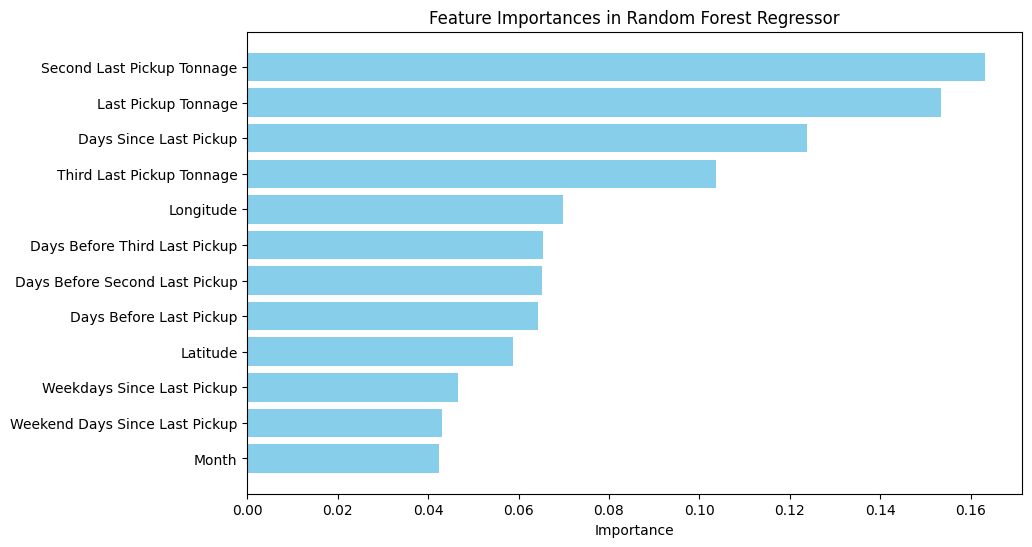

In [15]:
## Analyze feature importance

# Create the regressor model instance
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust the parameters

# Fit the model to your scaled training data
random_forest.fit(X_train_scaled, y_train_non_superstores)

# Retrieve feature importances from the model
feature_importances = random_forest.feature_importances_

# Assuming X_train_scaled is a numpy array and you have the original feature names in a list
feature_names = X_train.columns  # replace with your actual feature names

# Create a DataFrame to view the feature importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Sort importances
importances_sorted = importances_df.sort_values(by='Importance')

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_sorted['Feature'], importances_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Regressor')
plt.show()



In [16]:
## Grid search for hyperparameter tuning

# Define the model
gbr = GradientBoostingRegressor()

# Create a parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

best_model = None
best_mse = np.inf
best_params = {}
count = 1
for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            print("Testing configuration " + str(count))
            model.set_params(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
            model.fit(X_train_scaled, y_train_non_superstores)
            y_pred = model.predict(X_test_scaled)
            mse = mean_squared_error(y_test_non_superstores, y_pred)
            
            if mse < best_mse:
                best_mse = mse
                best_model = model
                best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}
            count += 1

print("Best Parameters:", best_params)
print("Best MSE:", best_mse)



Testing configuration 1
Testing configuration 2
Testing configuration 3
Testing configuration 4
Testing configuration 5
Testing configuration 6
Testing configuration 7
Testing configuration 8
Testing configuration 9
Testing configuration 10
Testing configuration 11
Testing configuration 12
Testing configuration 13
Testing configuration 14
Testing configuration 15
Testing configuration 16
Testing configuration 17
Testing configuration 18
Testing configuration 19
Testing configuration 20
Testing configuration 21
Testing configuration 22
Testing configuration 23
Testing configuration 24
Testing configuration 25
Testing configuration 26
Testing configuration 27
Best Parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 4}
Best MSE: 4.005436316732316
